## assignment: classify stuff

First we need to pick a dataset: let's just use dogs v. cats, keep it simple and learn to do it.
The other idea was to go from image -> city, but let's get it working on dogs v cats first.%matplotlib inline

First let's do some setup:

In [1]:
%matplotlib inline
path = "data/dogscats/sample/"
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [2]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Now let's import the stuff needed for direct keras usage

In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam

This code is to import the imagenet classes:

In [4]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [5]:
print(classes[100:110])

[u'black_swan', u'tusker', u'echidna', u'platypus', u'wallaby', u'koala', u'wombat', u'jellyfish', u'sea_anemone', u'brain_coral']


Ok we have our classes. Now I'm just gonna paste the VGG code. I don't think re-implementing that will be very instructive. It's just calling model.add(SOMETHING-FROM-KERAS) several times to create a topography.

In [6]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

Ok let's create our VGG model

In [7]:
model = VGG_16()

Ok time to get the weights the VGG author trained with imagenet

In [8]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [9]:
# get_file is from the keras utils. Gets a file if it is not already in the cache. It really helps for jupyter
print(FILES_PATH)

http://files.fast.ai/models/


Have a variable to let us adjust this later:

In [34]:
batch_size = 48

This is just a shorthand function for `ImageDataGenerator::flow_from_directory`. ImageDataGenerator is a class that helps you generate batches of images in the format needed for passing to our models. Basically it will give us an infinite iterator of these batch objects which should let us interact with our image samples in a normalized way.

In [11]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [12]:
print(path)

data/dogscats/sample/


`get_batches` uses the `path` variable to know where to read stuff from. Then you just pass "train" or "valid" in and that will be what it uses to give us our stream of batches. Next: create two "batch-streams", `batches`, of training data and `valid`, for validation data. We have both of these subdirectories whether we're using the main dataset or the "sample" dataset.

In [31]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


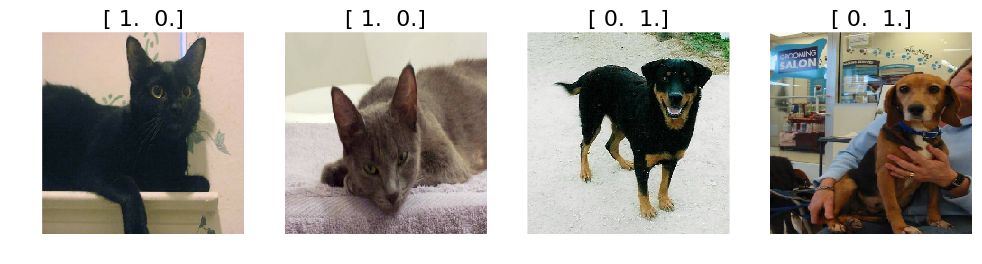

In [14]:
plots(imgs, titles=labels)

As you can see, cats are represented by [1, 0] and dogs [0, 1]. There are several ways ImageDataGenerator can produce these labels but the important thing to see is `class_mode='categorical'`.  From the keras docs:

> "categorical" will be 2D one-hot encoded labels

The docs will also tell you that the classes, if not provided, are automatically generated from the subdirectories of the passed directory.

Next: a function to run the VGG model on a batch of images. `np.argmax` is needed to get the highest probability of probability vector that is the output of the prediction.

In [15]:
imgs[0][0][0][0]

209.0

In [16]:
len(imgs), len(imgs[0]), len(imgs[0][0]), len(imgs[0][0][0])

(4, 3, 224, 224)

Notice that we set the batch size to 4, this is why `imgs`, a 4-dimentional array, has 4 top level elements. The next dimension is just colour, so there are three elements. Then we just have a regular 2d array which is the color channel of the image itself.

In [36]:
labels

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

`labels` is just an array of vectors, which are the labels.

In [17]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [26]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.2095e-07   8.4052e-06   8.2559e-07   5.7646e-07   1.3834e-06]

Predictions prob/class: 
  0.5164/tabby
  0.2684/toy_terrier
  0.5375/Egyptian_cat
  0.3414/miniature_pinscher


In [40]:
samplePreds = model.predict(imgs)

In [41]:
samplePreds

array([[  1.2095e-07,   8.4052e-06,   8.2559e-07, ...,   2.0857e-07,   1.4938e-04,   3.0650e-03],
       [  2.6524e-05,   1.0107e-05,   6.6178e-05, ...,   4.0122e-05,   1.4490e-03,   3.1767e-03],
       [  1.3526e-07,   4.2185e-07,   2.8940e-05, ...,   9.7323e-08,   6.0626e-05,   4.9876e-04],
       [  2.0621e-06,   4.5907e-06,   3.3851e-07, ...,   1.1676e-06,   1.4846e-04,   4.1334e-04]], dtype=float32)

Predictions come as a 2D array, the first dimension is length 4 because that's our batch size. The next is length 1000 because that's the output of our VGG model, one for each of the 1000 imagenet classes.

##### So this is where the lesson notebook stops. Everything past this is what I've written for myself based on analysis of the vgg16.py file and my own research.

First I'll set up a function to reshape our network to only have two output probabilities, similar to the `ft` method in the VGG16 class. The recipe is something like
- Take a model, remove the last layer
- Lock every layer to ensure it won't be trained any more
- Add a dense layer that has only two outputs
- Re-compile the model

In [18]:
def convertToTwoClass(model):
  model.pop()
  for layer in model.layers: layer.trainable=False
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer=Adam(lr=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])

Next I'll do a function that can "retrain" the new network to recognise dogs from cats.

In [19]:
classes = list(iter(batches.class_indices)) # get a list of all the class labels
classes

['cats', 'dogs']

In [20]:
# the above works because of the structure of batches.class_indices:
batches.class_indices

{'cats': 0, 'dogs': 1}

As you can see, `class_indices` should be called class_to_index as that is what it does.

In [21]:
# sort the class labels by index according to batches.class_indices and update model.classes
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c


In [22]:
classes

['cats', 'dogs']

That odd block above is to ensure that `classes` is sorted correctly by the class index, as we'll be indexing into it to get our prediction. Seems a bit _convuluted_, get it? Anyway all that for one `classes` variable which should have the value `['cats', 'dogs']`.

In [23]:
def retrain(model, batches, val_batches, nb_epoch = 1):
    model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

The above is a simple shorthand for calling `fit_generator` on a model. We pass it two generators, one for training data and one for validation data. Hopefully it will train our weights to more accurately predict cats and dogs. Let's try it out!

In [24]:
model = VGG_16()
model.load_weights(fpath)
convertToTwoClass(model)

In [30]:
path = "data/dogscats/"

In [32]:
retrain(model, batches, val_batches)

Epoch 1/1
23000/23000 [==============================] - 704s - loss: 0.2254 - acc: 0.9705 - val_loss: 0.2371 - val_acc: 0.9755


If you run this once you get about 62% accuracy with the sample set. Running it more times seems to reduce the accuracy, I suppose because the weights are being over-fit. I'll have to try running it with the full dataset on AWS and I'll report back once I have.

The first run with the full dataset on AWS yielded `704s - loss: 0.2254 - acc: 0.9705 - val_loss: 0.2371 - val_acc: 0.9755`

In [43]:
kaggle_test_path = "data/dogscats_kaggle/test_flow"

Let's try to flow the test data from directory like we do with the training data

In [64]:
kaggle_test_batches = image.ImageDataGenerator().flow_from_directory(kaggle_test_path,
                                                                     target_size=(224,224), batch_size=1,
                                                                     class_mode=None,
                                                                    shuffle=False)


Found 12500 images belonging to 1 classes.


Now let's run our prediction:

In [59]:
predictions = model.predict(batch)
isDogs = np.argmax(predictions, axis = 1)
isDogs

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1])

In [85]:
predictions = model.predict_generator(kaggle_test_batches, 12500, 10, 1, True)

isDogs = np.argmax(predictions, axis = 1)
isDogs

array([0, 1, 1, ..., 0, 0, 1])

In [86]:
len(predictions)

12500

[[  7.0065e-45   1.0000e+00]]
dog


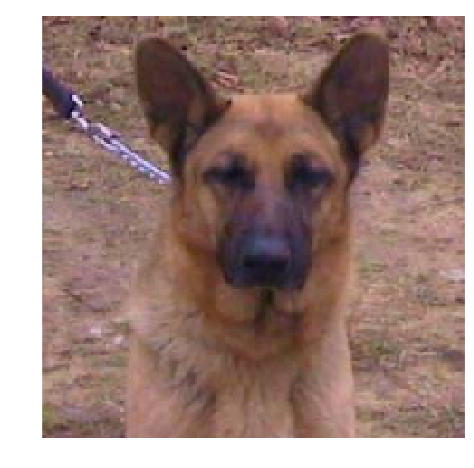

In [84]:
# do a small test to check we're not crazy
smallSample = next(kaggle_test_batches)
prediction = model.predict(smallSample)
isDog = not (np.argmax(prediction) == 0)
print(prediction)
if isDog:
    print("dog")
else:
    print("cat")
plots(smallSample)

In [88]:
# output predictions to file so I can just down the expensive AWS machine
outfile = open("lesson1-kaggle.np", "w")
np.save(outfile, predictions)

In [87]:
# turn `predictions` into a CSV file for kaggle


Here is some text 














~ Just here to let me keep shit in the middle of the screen.